In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

#### Load Toronto Data

In [2]:
csv_path='https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv'
df = pd.read_csv(csv_path,encoding='latin1')
df.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,...,37,7,137,64,60,94,100,97,27,31
1,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526","27,695",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177","26,918",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,2.90%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


### Preprocessing

In [3]:
# Create toronto dataframe
toronto_df = pd.DataFrame(columns=['Neighbourhood'])
toronto_df['Neighbourhood'] = df.columns.values[5:]

#####################
# Get location for each Neighborhood
lat_list = np.zeros((len(toronto_df)))
lng_list = np.zeros((len(toronto_df)))
for i in range(len(toronto_df)):
    address = '{}, Toronto, Canada'.format(toronto_df['Neighbourhood'][i])
    geolocator = Nominatim(user_agent="ny_explorer")
    try:
        location = geolocator.geocode(address)
        lat_list[i] = location.latitude
        lng_list[i] = location.longitude
    except:
        lat_list[i] = None
        lng_list[i] = None

toronto_df['Latitude'] = lat_list
toronto_df['Longitude'] = lng_list
toronto_df.dropna(subset=['Latitude', 'Longitude'], axis=0, inplace=True)
toronto_df.reset_index(drop=True, inplace=True)
########################
toronto_df.head()

,Neighbourhood,Latitude,Longitude
0,Agincourt North,43.808038,-79.266439
1,Alderwood,43.601717,-79.545232
2,Annex,43.670338,-79.407117
3,Banbury-Don Mills,43.751672,-79.370169
4,Bathurst Manor,43.665519,-79.411937


To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in meters).

In [4]:
import shapely.geometry
import pyproj
import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

#### Downtown Location and (X/Y coordinates in meters)

In [5]:
address = 'Downtown, Toronto, Canada'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
toronto_downtown_latitude = location.latitude
toronto_downtown_longitude = location.longitude
toronto_downtown_x , toronto_downtown_y = lonlat_to_xy(toronto_downtown_longitude, toronto_downtown_latitude)
print('Toronto Downtown Latitude is {} , Longitude is {} '.format(toronto_downtown_latitude,toronto_downtown_longitude))
print('Toronto Downtown X is {} , Y is {} '.format(toronto_downtown_x,toronto_downtown_y))

Toronto Downtown Latitude is 43.6563221 , Longitude is -79.3809161 
Toronto Downtown X is -5310113.887470545 , Y is 10507139.76433715 


<ipython-input-4-73d86651f759>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)


#### Calculate distance from Downtown for each Neighborhood

In [6]:
xs = np.zeros(len(toronto_df))
ys = np.zeros(len(toronto_df))
distances_from_Downtown = np.zeros(len(toronto_df))

for row in range(len(toronto_df)):
    xs[row], ys[row] = lonlat_to_xy(toronto_df['Longitude'][row], toronto_df['Latitude'][row])
    distances_from_Downtown[row] = calc_xy_distance(toronto_downtown_x, toronto_downtown_y, xs[row], ys[row])
    
toronto_df['X'] = xs
toronto_df['Y'] = ys
toronto_df['Distance From Downtown'] = distances_from_Downtown
toronto_df.head()

<ipython-input-4-73d86651f759>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-4-73d86651f759>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-4-73d86651f759>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-4-73d86651f759>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-4-73d86651f759>:8: DeprecationWarning: This function 

,Neighbourhood,Latitude,Longitude,X,Y,Distance From Downtown
0,Agincourt North,43.808038,-79.266439,-5.287439e+06,1.049132e+07,27647.850931
1,Alderwood,43.601717,-79.545232,-5.316662e+06,1.052711e+07,21017.537200
2,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005
3,Banbury-Don Mills,43.751672,-79.370169,-5.295093e+06,1.050423e+07,15300.828430
4,Bathurst Manor,43.665519,-79.411937,-5.308253e+06,1.051056e+07,3893.566103


In [7]:
# we interested only with the Neighborhoods within the range of 6->km from Downtown
toronto_df = toronto_df[toronto_df['Distance From Downtown'] <= 6000]
toronto_df.head()

,Neighbourhood,Latitude,Longitude,X,Y,Distance From Downtown
2,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005
4,Bathurst Manor,43.665519,-79.411937,-5.308253e+06,1.051056e+07,3893.566103
5,Bay Street Corridor,43.668865,-79.389126,-5.308014e+06,1.050787e+07,2222.603250
10,Broadview North,43.683924,-79.356964,-5.306028e+06,1.050389e+07,5220.545451
11,Casa Loma,43.678101,-79.409416,-5.306285e+06,1.051005e+07,4807.361366


#### Lets map Downtown with red color and the other Neighborhoods with blue color

In [8]:
map_toronto = folium.Map(location = [toronto_downtown_latitude, toronto_downtown_longitude], zoom_start = 12)
# add markers to map

folium.CircleMarker(
        [toronto_downtown_latitude, toronto_downtown_longitude],
        radius=5,
        popup='Downtown',
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)

for lat, lng, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)
    
map_toronto

#### Foursquare credentials

In [15]:
CLIENT_ID = '***************************************' # your Foursquare ID
CLIENT_SECRET = '*****************************************' # your Foursquare Secret
ACCESS_TOKEN = '*****************************************' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 750 # define radius

#### Let's create a function to get venues to all the neighborhoods in Toronto city

In [16]:
def getNearbyVenues(names, latitudes, longitudes, Xs, Ys, Distances, radius=500):
    
    venues_list=[]
    for name, lat, lng, x, y, distance in zip(names, latitudes, longitudes, Xs, Ys, Distances):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng,
            ACCESS_TOKEN,
            VERSION, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng,
            x,
            y,
            distance,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Neighborhood X',
                  'Neighborhood Y',
                  'Neighborhood Distance From Downtown',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### get venues to all the neighborhoods in Toronto

In [17]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                 latitudes=toronto_df['Latitude'],
                                 longitudes=toronto_df['Longitude'],
                                 Xs=toronto_df['X'],
                                 Ys=toronto_df['Y'],
                                 Distances=toronto_df['Distance From Downtown'] 
                                 )

Annex
Bathurst Manor
Bay Street Corridor
Broadview North
Casa Loma
Church-Yonge Corridor
Dufferin Grove
Moss Park
Niagara
North Riverdale
North St. James Town
Palmerston-Little Italy
Playter Estates-Danforth
Regent Park
Rosedale-Moore Park
South Riverdale
St.Andrew-Windfields
Trinity-Bellwoods
Yonge-St.Clair


#### Let's check the size of the resulting dataframe

In [18]:
toronto_venues.shape

(1241, 10)

In [19]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Neighborhood X,Neighborhood Y,Neighborhood Distance From Downtown,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Jean Sibelius Square,43.671426,-79.408831,Park
1,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Fresh on Bloor,43.666755,-79.403491,Vegetarian / Vegan Restaurant
2,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant
3,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Fuwa Fuwa Japanese Pancakes,43.665880,-79.407840,Pastry Shop
4,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,The Original Gyro Grill,43.666621,-79.405544,Greek Restaurant


#### Let's find out how many unique categories can be curated from all the returned venues

In [20]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 208 uniques categories.


### Let's create the dataframe which contains only restaurant venues

In [21]:
restaurants_df = toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant")]
restaurants_df.reset_index(drop=True, inplace=True)

In [22]:
print('There are {} uniques Restaurant.'.format(len(restaurants_df['Venue Category'].unique())))

There are 42 uniques Restaurant.


In [23]:
restaurants_df.shape

(351, 10)

In [24]:
restaurants_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Neighborhood X,Neighborhood Y,Neighborhood Distance From Downtown,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Fresh on Bloor,43.666755,-79.403491,Vegetarian / Vegan Restaurant
1,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant
2,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,The Original Gyro Grill,43.666621,-79.405544,Greek Restaurant
3,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Real Thailand Restaurant,43.666557,-79.404657,Thai Restaurant
4,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Famoso Neapolitan Pizzeria,43.666196,-79.406564,Italian Restaurant


### Let's create the dataframe which contains only the italian restaurants

In [25]:
italian_restaurants_df = toronto_venues[toronto_venues['Venue Category'].str.contains("Italian Restaurant")]
italian_restaurants_df.reset_index(drop=True, inplace=True)

In [26]:
italian_restaurants_df.shape

(33, 10)

In [27]:
italian_restaurants_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Neighborhood X,Neighborhood Y,Neighborhood Distance From Downtown,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Famoso Neapolitan Pizzeria,43.666196,-79.406564,Italian Restaurant
1,Bathurst Manor,43.665519,-79.411937,-5.308253e+06,1.051056e+07,3893.566103,Famoso Neapolitan Pizzeria,43.666196,-79.406564,Italian Restaurant
2,Bay Street Corridor,43.668865,-79.389126,-5.308014e+06,1.050787e+07,2222.603250,Trattoria Nervosa,43.671019,-79.391081,Italian Restaurant
3,Bay Street Corridor,43.668865,-79.389126,-5.308014e+06,1.050787e+07,2222.603250,Blu Ristorante and Lounge,43.671685,-79.388614,Italian Restaurant
4,Bay Street Corridor,43.668865,-79.389126,-5.308014e+06,1.050787e+07,2222.603250,Buca,43.671917,-79.389236,Italian Restaurant


### simple statistics about the restaurants

In [28]:
total_num_of_restaurants = len(restaurants_df)
total_num_of_italian_restaurants = len(italian_restaurants_df)
print('Total number of restaurants:', total_num_of_restaurants)
print('Total number of Italian restaurants:', total_num_of_italian_restaurants)
print('Percentage of Italian restaurants: {:.2f}%'.format(total_num_of_italian_restaurants / total_num_of_restaurants * 100))

Total number of restaurants: 351
Total number of Italian restaurants: 33
Percentage of Italian restaurants: 9.40%


#### Let's create the column which contains the total number of restaurants in each neighborhood

In [29]:
num_restaurants_in_neighborhood = (restaurants_df.groupby('Neighborhood').count())[['Venue']]
num_restaurants_in_neighborhood.reset_index(inplace=True)
num_restaurants_in_neighborhood.rename(columns={'Venue':'Restaurants in neighbohood'}, inplace=True)
restaurants_df = pd.merge(restaurants_df, num_restaurants_in_neighborhood, on='Neighborhood')
restaurants_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Neighborhood X,Neighborhood Y,Neighborhood Distance From Downtown,Venue,Venue Latitude,Venue Longitude,Venue Category,Restaurants in neighbohood
0,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Fresh on Bloor,43.666755,-79.403491,Vegetarian / Vegan Restaurant,16
1,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant,16
2,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,The Original Gyro Grill,43.666621,-79.405544,Greek Restaurant,16
3,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Real Thailand Restaurant,43.666557,-79.404657,Thai Restaurant,16
4,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,Famoso Neapolitan Pizzeria,43.666196,-79.406564,Italian Restaurant,16


### Let's create the column which contains the distance to every italian restaurant within each neighborhood

In [30]:
xs = np.zeros(len(italian_restaurants_df))
ys = np.zeros(len(italian_restaurants_df))
distances_to_italian_restaurant = np.zeros(len(italian_restaurants_df))
for row in range(len(italian_restaurants_df)):
    xs[row], ys[row] = lonlat_to_xy(italian_restaurants_df['Venue Longitude'][row], italian_restaurants_df['Venue Latitude'][row])
    distances_to_italian_restaurant[row] = calc_xy_distance(italian_restaurants_df['Neighborhood X'][row], italian_restaurants_df['Neighborhood Y'][row], xs[row], ys[row])

# italian_restaurants_df['Distance to Italian Restaurant'] = distances_to_italian_restaurant
italian_restaurants_df.insert(6, 'Neiborhood Distance to Italian Restaurant', distances_to_italian_restaurant)
italian_restaurants_df.head()

<ipython-input-4-73d86651f759>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-4-73d86651f759>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-4-73d86651f759>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-4-73d86651f759>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-4-73d86651f759>:8: DeprecationWarning: This function 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Neighborhood X,Neighborhood Y,Neighborhood Distance From Downtown,Neiborhood Distance to Italian Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Annex,43.670338,-79.407117,-5.307549e+06,1.050992e+07,3781.433005,665.860717,Famoso Neapolitan Pizzeria,43.666196,-79.406564,Italian Restaurant
1,Bathurst Manor,43.665519,-79.411937,-5.308253e+06,1.051056e+07,3893.566103,633.570247,Famoso Neapolitan Pizzeria,43.666196,-79.406564,Italian Restaurant
2,Bay Street Corridor,43.668865,-79.389126,-5.308014e+06,1.050787e+07,2222.603250,412.810863,Trattoria Nervosa,43.671019,-79.391081,Italian Restaurant
3,Bay Street Corridor,43.668865,-79.389126,-5.308014e+06,1.050787e+07,2222.603250,455.224421,Blu Ristorante and Lounge,43.671685,-79.388614,Italian Restaurant
4,Bay Street Corridor,43.668865,-79.389126,-5.308014e+06,1.050787e+07,2222.603250,488.550501,Buca,43.671917,-79.389236,Italian Restaurant


### Let's show the distribution of all restaurants (italian resturants with **red** color and others with **blue**)

In [31]:
map_toronto = folium.Map(location = [toronto_downtown_latitude, toronto_downtown_longitude], zoom_start = 12)
# add markers to map

for lat, lng, venue in zip(restaurants_df['Venue Latitude'], restaurants_df['Venue Longitude'], restaurants_df['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)

for lat, lng, venue in zip(italian_restaurants_df['Venue Latitude'], italian_restaurants_df['Venue Longitude'], italian_restaurants_df['Venue']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)
    
map_toronto

### Let's crete a map showing heatmap / density of restaurants and try to extract some meaningfull info from that

In [32]:
restaurant_latlons = [[restaurant[1], restaurant[2]] for restaurant in restaurants_df.values]

italian_latlons = [[restaurant[1], restaurant[2]] for restaurant in italian_restaurants_df.values]

##### **heatmap/density of all restaurants**

In [33]:
from folium import plugins
from folium.plugins import HeatMap

map_toronto = folium.Map(location = [toronto_downtown_latitude, toronto_downtown_longitude], zoom_start = 12.7)

folium.CircleMarker(
        [toronto_downtown_latitude, toronto_downtown_longitude],
        radius=5,
        popup='Downtown',
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)

folium.TileLayer('cartodbpositron').add_to(map_toronto) #cartodbpositron cartodbdark_matter
HeatMap(restaurant_latlons).add_to(map_toronto)
folium.Marker([toronto_downtown_latitude, toronto_downtown_longitude]).add_to(map_toronto)
folium.Circle([toronto_downtown_latitude, toronto_downtown_longitude], radius=1000, fill=False, color='white').add_to(map_toronto)
folium.Circle([toronto_downtown_latitude, toronto_downtown_longitude], radius=2000, fill=False, color='white').add_to(map_toronto)
folium.Circle([toronto_downtown_latitude, toronto_downtown_longitude], radius=3000, fill=False, color='white').add_to(map_toronto)
# folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_toronto)
map_toronto

#####  **heatmap/density of Italian restaurants only**

In [34]:
map_toronto = folium.Map(location = [toronto_downtown_latitude, toronto_downtown_longitude], zoom_start = 12.7)

folium.CircleMarker(
        [toronto_downtown_latitude, toronto_downtown_longitude],
        radius=5,
        popup='Downtown',
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)

folium.TileLayer('cartodbpositron').add_to(map_toronto) #cartodbpositron cartodbdark_matter
HeatMap(italian_latlons).add_to(map_toronto)
folium.Marker([toronto_downtown_latitude, toronto_downtown_longitude]).add_to(map_toronto)
folium.Circle([toronto_downtown_latitude, toronto_downtown_longitude], radius=1000, fill=False, color='white').add_to(map_toronto)
folium.Circle([toronto_downtown_latitude, toronto_downtown_longitude], radius=2000, fill=False, color='white').add_to(map_toronto)
folium.Circle([toronto_downtown_latitude, toronto_downtown_longitude], radius=3000, fill=False, color='white').add_to(map_toronto)
# folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_toronto)
map_toronto

In [35]:
from folium import plugins

# let's start again with a clean copy of the map of San Francisco
map_toronto = folium.Map(location = [toronto_downtown_latitude, toronto_downtown_longitude], zoom_start = 13)

folium.CircleMarker(
        [toronto_downtown_latitude, toronto_downtown_longitude],
        radius=5,
        popup='Downtown',
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)

# instantiate a mark cluster object for the incidents in the dataframe
restaurants = plugins.MarkerCluster().add_to(map_toronto)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(italian_restaurants_df['Neighborhood Latitude'], italian_restaurants_df['Neighborhood Longitude'], italian_restaurants_df['Venue Category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(restaurants)

# display map
map_toronto

#### **Highest concentration of restaurants was detected north and west from Downtown, so we will focuse our attention to areas south, south-east and east**

In [36]:
df_Neiborhood = pd.DataFrame(columns=['Neighborhood', 'Neighborhood Distance from Downtown', 'Neighborhood Average Distance to Italian Restaurant', 'Italian Restaurants in Neighborhood'])
df_Neiborhood

,Neighborhood,Neighborhood Distance from Downtown,Neighborhood Average Distance to Italian Restaurant,Italian Restaurants in Neighborhood


In [37]:
df_Neiborhood['Neighborhood'] = italian_restaurants_df['Neighborhood'].unique()
df_Neiborhood['Neighborhood Distance from Downtown'] = italian_restaurants_df['Neighborhood Distance From Downtown'].unique()
average = []
for nei in italian_restaurants_df['Neighborhood'].unique():
    l = italian_restaurants_df[italian_restaurants_df['Neighborhood'] == nei]
    ls = l['Neiborhood Distance to Italian Restaurant'].to_numpy()
    average.append(np.mean(ls))
df_Neiborhood['Neighborhood Average Distance to Italian Restaurant'] = average
num_rest_df=((restaurants_df.groupby(['Neighborhood']).count())[['Venue']]).reset_index()
num_rest_df.rename(columns={'Venue':'Total Restaurants in Neighborhood'}, inplace=True)
df_Neiborhood = pd.merge(df_Neiborhood, num_rest_df, on='Neighborhood')
df_Neiborhood['Italian Restaurants in Neighborhood'] = (italian_restaurants_df.groupby(['Neighborhood']).count())['Venue'].values

df_Neiborhood

,Neighborhood,Neighborhood Distance from Downtown,Neighborhood Average Distance to Italian Restaurant,Italian Restaurants in Neighborhood,Total Restaurants in Neighborhood
0,Annex,3781.433005,665.860717,1,16
1,Bathurst Manor,3893.566103,633.570247,1,37
2,Bay Street Corridor,2222.603250,452.927237,4,30
3,Church-Yonge Corridor,2815.917939,420.395632,5,30
4,Dufferin Grove,5308.174412,439.791570,5,20
5,Moss Park,1327.800979,485.132152,4,18
6,Niagara,3777.940174,383.166767,1,23
7,North St. James Town,2300.852910,623.328355,2,9
8,Playter Estates-Danforth,4636.183478,480.191933,2,27
9,St.Andrew-Windfields,1440.871436,500.231430,2,27


In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

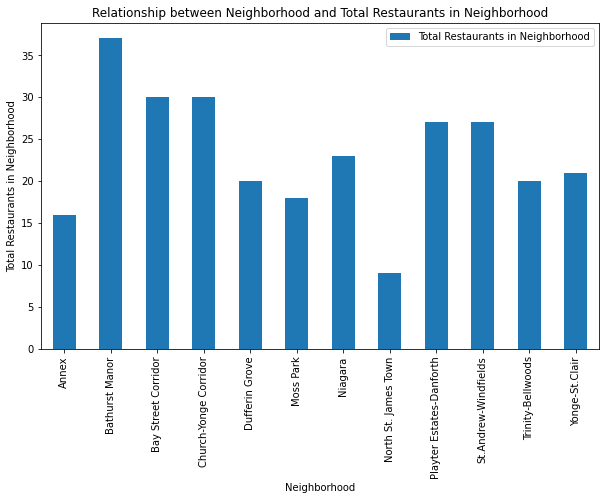

In [41]:
# Relationship between Neighborhood and Total Restaurants in Neighborhood
nei_tot_df = df_Neiborhood[['Neighborhood', 'Total Restaurants in Neighborhood']]
nei_tot_df.set_index('Neighborhood', inplace=True)
nei_tot_df.plot(kind='bar', figsize=(10,6), rot=90)
plt.xticks(range(len(nei_tot_df.index)), nei_tot_df.index)
plt.title('Relationship between Neighborhood and Total Restaurants in Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Total Restaurants in Neighborhood')
plt.show()

#### We find that 'North St. James Town' contains the smallest total number of restaurants

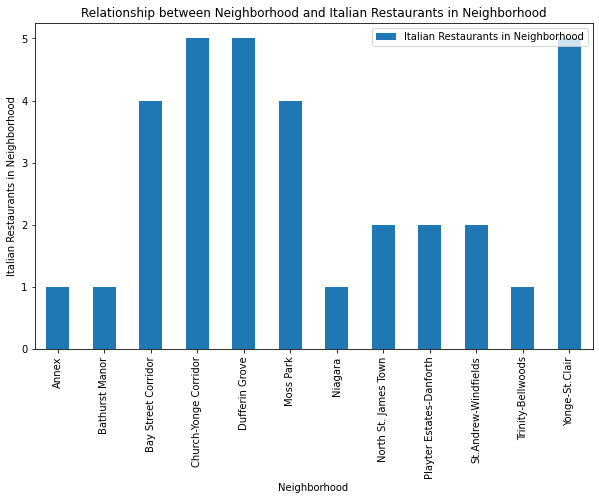

In [42]:
# Relationship between Neighborhood and Italian Restaurants in Neighborhood
nei_ital_df = df_Neiborhood[['Neighborhood', 'Italian Restaurants in Neighborhood']]
nei_ital_df.set_index('Neighborhood', inplace=True)
nei_ital_df.plot(kind='bar', figsize=(10,6), rot=90)
plt.xticks(range(len(nei_ital_df.index)), nei_ital_df.index)
plt.title('Relationship between Neighborhood and Italian Restaurants in Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Italian Restaurants in Neighborhood')
plt.show()

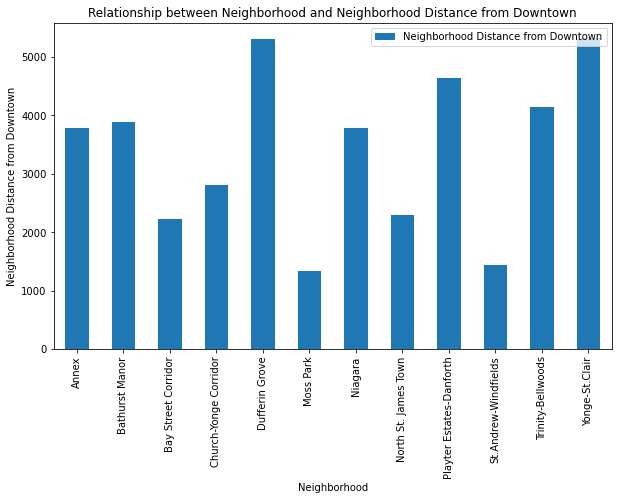

In [43]:
# Relationship between Neighborhood and Neighborhood Distance from Downtown
nei_dist_to_downtown_df = df_Neiborhood[['Neighborhood', 'Neighborhood Distance from Downtown']]
nei_dist_to_downtown_df.set_index('Neighborhood', inplace=True)
nei_dist_to_downtown_df.plot(kind='bar', figsize=(10,6), rot=90)
plt.xticks(range(len(nei_dist_to_downtown_df.index)), nei_dist_to_downtown_df.index)
plt.title('Relationship between Neighborhood and Neighborhood Distance from Downtown')
plt.xlabel('Neighborhood')
plt.ylabel('Neighborhood Distance from Downtown')
plt.show()

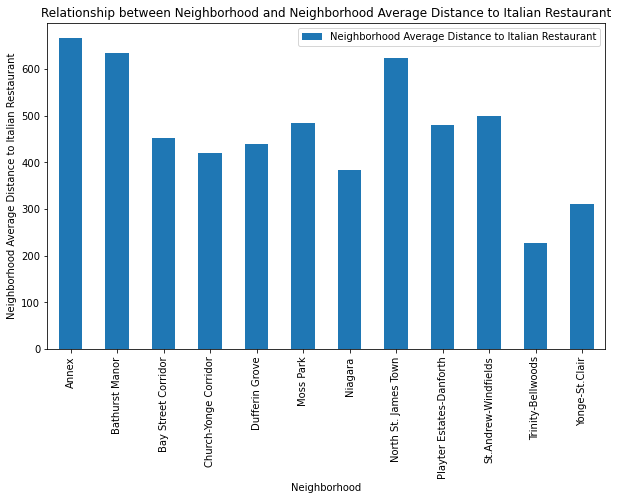

In [44]:
# Relationship between Neighborhood and Italian Neighborhood Average Distance to Italian Restaurant
nei_dist_ital_rest_df = df_Neiborhood[['Neighborhood', 'Neighborhood Average Distance to Italian Restaurant']]
nei_dist_ital_rest_df.set_index('Neighborhood', inplace=True)
nei_dist_ital_rest_df.plot(kind='bar', figsize=(10,6), rot=90)
plt.xticks(range(len(nei_dist_ital_rest_df.index)), nei_dist_ital_rest_df.index)
plt.title('Relationship between Neighborhood and Neighborhood Average Distance to Italian Restaurant')
plt.xlabel('Neighborhood')
plt.ylabel('Neighborhood Average Distance to Italian Restaurant')
plt.show()

#### we will filter our results to contains only neighborhoods with two or less italian restaurants and within the range of 2.5km

In [45]:
df_good_locations = df_Neiborhood[(df_Neiborhood['Italian Restaurants in Neighborhood'] <= 2) & (df_Neiborhood['Neighborhood Distance from Downtown'] <= 2500)]
df_good_locations

,Neighborhood,Neighborhood Distance from Downtown,Neighborhood Average Distance to Italian Restaurant,Italian Restaurants in Neighborhood,Total Restaurants in Neighborhood
7,North St. James Town,2300.852910,623.328355,2,9
9,St.Andrew-Windfields,1440.871436,500.231430,2,27


#### we find that **North St. James Town**  neighborhood is a good location as it has **smaller** total number of Restaurants in Neighborhood and **larger** average distance to the Italian Restaurants within a neighborhood

# Clustering Model (K-Means)

In [46]:
from sklearn.preprocessing import StandardScaler
X = (df_Neiborhood.drop('Neighborhood',axis=1)).values
X = StandardScaler().fit_transform(X)
X[0:5]

array([[ 0.27817426,  1.58778953, -1.06748999, -0.99892009],
       [ 0.3629586 ,  1.32795212, -1.06748999,  1.92814807],
       [-0.90046386, -0.12565981,  0.76249285,  0.95245869],
       [-0.45185598, -0.3874376 ,  1.37248713,  0.95245869],
       [ 1.43255024, -0.23136089,  1.37248713, -0.44138329]])

In [47]:
from sklearn.cluster import KMeans

kclusters = 4
k_means = KMeans(n_clusters=kclusters, random_state=0)
k_means.fit(X)
labels = k_means.labels_
centers = k_means.cluster_centers_

In [48]:
df_Neiborhood['Cluster_label'] = labels
df_Neiborhood['Latitude'] = italian_restaurants_df['Neighborhood Latitude'].unique()
df_Neiborhood['Longitude'] = italian_restaurants_df['Neighborhood Longitude'].unique()

In [49]:
df_Neiborhood.head()

,Neighborhood,Neighborhood Distance from Downtown,Neighborhood Average Distance to Italian Restaurant,Italian Restaurants in Neighborhood,Total Restaurants in Neighborhood,Cluster_label,Latitude,Longitude
0,Annex,3781.433005,665.860717,1,16,2,43.670338,-79.407117
1,Bathurst Manor,3893.566103,633.570247,1,37,1,43.665519,-79.411937
2,Bay Street Corridor,2222.603250,452.927237,4,30,0,43.668865,-79.389126
3,Church-Yonge Corridor,2815.917939,420.395632,5,30,0,43.673083,-79.388289
4,Dufferin Grove,5308.174412,439.791570,5,20,3,43.653632,-79.426439


In [50]:
map_toronto = folium.Map(location = [toronto_downtown_latitude, toronto_downtown_longitude], zoom_start = 11.7)
# add markers to map

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lng, neighborhood, cluster in zip(df_Neiborhood['Latitude'], df_Neiborhood['Longitude'], df_Neiborhood['Neighborhood'], df_Neiborhood['Cluster_label']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
    
map_toronto